<img src="https://raw.githubusercontent.com/ContinualCausality/Causality-Tutorial/main/Banner-Tutorial.png" height="200"/>

<h1>Code Tutorial on Different Causality Topics</h1>

This tutorial combines elements from two previously existing tutorials. One of them first authored by [Alexandre Drouin](https://www.alexdrouin.com/) with contributions from [Philippe Brouillard](https://philippe-brouillard.com/) and [Thibaud Godon](https://github.com/thibgo). We are grateful for the amazing scientists involved in making this tutorial a reality, thank you!

<br />

**Abstract:** This tutorial will consist of 5 exercises. We will cover the famous Simpson's paradox and accordingly follow up with a practical introduction to the estimation of causal effects. We will experiment with the concepts of average treatment effect, randomization, covariate adjustment, and inverse probability weighting to derive common estimators from the literature. We will also see where machine learning models fit into such estimators. Formal derivations will be presented and supported by extensive visualizations. Finally, we will give some examples of causal discovery for learning any of the causal structures that we assume/model in the first place.

<br />

**Outline**
 * Exercise 1: Simpson's paradox (15 min)
 * Exercise 2: Identification and estimation via parent adjustment (20 min)
 * Exercise 3: From parent to back-door adjustment (20 min)
 * Exercise 4: Estimation via machine learning (15 min)
 * Exercise 5: Causal Structure Learning (10 min)

<br />

**Before you start**
 * Enable GPU in your environment in the menu via `Runtime -> Change runtime type` and setting the "hardware accelerator" to GPU. If it fails due to GPUs being unavailable, it's ok. Exercise 5 will just be longer to run.


<br />

 **Notes about the math:**
 
 * When writing probabilistic expressions, we will. use $P(a, b, c)$ instead of $P(A = a, B = b, C = c)$, unless it is required to disambiguate something.
 * In the equations, we assume discrete probabilities, but everything that we present can be generalized to the continuous case.
 * The presentation will focus on average treatment effects (ATE), but all the equations that we present can be generalized to include conditioning to estimate the conditional ATE (CATE).

## Utility functions

Run these functions to bootstrap the notebook.

In [ ]:
%pip install igraph
%pip install causal-learn
%pip install paginate-pandas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import utils
from string import ascii_uppercase
from sklearn.linear_model import LinearRegression
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc
from linear import notears_linear

In [2]:

import base64
from paginate_pandas import paginate
from IPython.display import HTML, display
from io import BytesIO
from PIL import Image
from torchvision.datasets import CIFAR10
from torchvision import transforms


def pprint_ates(ate):
    """
    Pretty print average treatment effect table
    
    """
    return HTML(pd.DataFrame([dict(method=k, ATE=v) for k, v in ate.items()]).to_html(index=False))


def generate_data_ex1(n_samples=10000, seed=42):
    random = np.random.RandomState(seed)

    Z = random.randint(0, 3, size=n_samples)
    
    policy = [0.05, 0.5, 0.9]  # Probability of treatment for each Z
    A = np.array([random.rand() <= policy[z] for z in Z]).astype(int)

    # Value of Z: 0     1    2
    survival = [[0.75, 0.25, 0.1],  # Untreated (A = 0)
                [0.95, 0.75, 0.25]]  # Treated (A = 1)
    Y = np.fromiter((random.rand() <= survival[A[i]][Z[i]] for i in range(n_samples)), dtype=int)

    return pd.DataFrame(dict(Z=Z, A=A, Y=Y))


def image_base64(img_array):
    """
    Convert an image from numpy array to bytes
    
    Adapted from https://www.kaggle.com/code/stassl/displaying-inline-images-in-pandas-dataframe/notebook

    """
    with BytesIO() as buffer:
        im = Image.fromarray(img_array)
        im.thumbnail((200, 200), Image.LANCZOS)
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    """
    Format image to show inline in dataframe

    Adapted from https://www.kaggle.com/code/stassl/displaying-inline-images-in-pandas-dataframe/notebook

    """
    return f'<img src="data:image/jpeg;base64,{im}" width="100">'


def generate_data_ex4b(randomize=False, seed=42):
    """
    Generate a dataset where confounding arises from a high-dimensional visual signal.

    We use images of cats and dogs from CIFAR10 to serve as confounder.

    """
    random = np.random.RandomState(seed)

    # Load image dataset
    base_dataset = CIFAR10(".", download=True)

    # Normalization applied to images
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Extract the list of indices for all individuals with class cat (3) and dog (5)
    class1_idx = np.where(np.array(base_dataset.targets) == 3)[0].tolist()
    class2_idx = np.where(np.array(base_dataset.targets) == 5)[0].tolist()

    # Keep only a few images and make them occur more than once
    # By doing this, we aim to create profiles of individuals
    # with the same visual profile (related to stratification)
    class1_idx = class1_idx[: 100] * 100
    class2_idx = class2_idx[: 100] * 100
    n_samples = len(class1_idx) + len(class2_idx)

    # Retrieve images from dataset and apply transformations
    Z = np.array(base_dataset.data[class1_idx + class2_idx])
    Z_normed = np.array([transform(z).numpy() for z in Z])

    # We assume that treatment was assigned based on perfect knowledge of the classes.
    Z_ = np.array([0] * len(class1_idx) + [1] * len(class2_idx))

    if randomize:
        policy = [0.5, 0.5]
    else:
        policy = [0.3, 0.7]  # Probability of treatment for each Z
    A = np.array([random.rand() <= policy[z] for z in Z_]).astype(int)

    # Value of Z:  0     1
    survival = [[0.75, 0.10],  # Untreated (A = 0)
                [0.95, 0.25]]  # Treated (A = 1)    
    Y = np.fromiter((random.rand() <= survival[A[i]][Z_[i]] for i in range(n_samples)), dtype=int)

    # Create a random permutation for the examples
    shuffler = np.arange(n_samples)
    random.shuffle(shuffler)

    # Assemble final dataset
    return pd.DataFrame(dict(Z=[z for z in Z_normed[shuffler]], A=A[shuffler], Y=Y[shuffler], 
                             Z_img=[image_base64(z) for z in Z[shuffler]], Z_=Z_[shuffler]))

## Exercise 1: Simpson's paradox (15 min)

In this exercise, we are going to dive into the notion of confounding by experimenting with a classical example: Simpson's paradox.

<img src="https://www.escardio.org/static-file/Escardio/Medias/education/covid-19/Covid-19-Webpage-banner-1170x240-opt2.jpg?mts=1594053162000.jpg">

**Context:** The world is confronted with a rare disease for which the world's public health agencies are urgently trying to find therapies. Scientists have proposed a new drug, but its effectiveness has not fully been demonstrated. As your government's top data scientist, you have been tasked with finding evidence of the drug's effectiveness. This is not a light task, your feedback will inform your country's treatment policy.

There is not enough time to run a clinical study. Instead, you have access to data collected in a neighbouring country, which has already started to use the drug on patients. The dataset contains the following variables:

1.   **Z**: severity of symptoms (mild=0, strong=1, critical=2)
2.   **A**: treatment that was administered (treated=1, untreated=0)
3.   **Y**: survival after one month (alive=1, dead=0)

Good luck.

Let's load this dataset and print the first few rows:

In [3]:
data = generate_data_ex1()
paginate(data, page_size=5)

10,000 rows, 3 columns


interactive(children=(IntSlider(value=1, description='Total pages: 2,000', max=2000, min=1, readout_format=','…

You are interested measuring the average treatment effect, that is, the chances of survival if someone *takes* vs. *does not take* the treatment. You decide to estimate the following quantity:
$$\mathbb{E}[Y \mid A = 1] - \mathbb{E}[Y \mid A = 0]$$

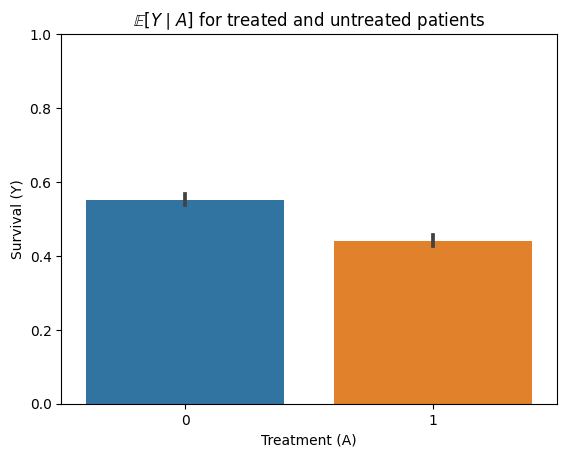

E[Y | A = 1] - E[Y | A = 0] =  -0.11025040157988131


In [4]:
sns.barplot(data=data, x="A", y="Y")
plt.ylim([0, 1])
plt.xlabel("Treatment (A)")
plt.ylabel("Survival (Y)")
plt.title("$\mathbb{E}[Y \mid A]$ for treated and untreated patients")
plt.show()

ate = {"conditionals": data.loc[data.A == 1].Y.mean() - data.loc[data.A == 0].Y.mean()}
print("E[Y | A = 1] - E[Y | A = 0] = ", ate["conditionals"])

**Q:** What do you conclude?

<details>
<summary>Click for answer</summary>

<strong>A:</strong> It looks like the treatment has a detrimental effect on survival, which suggets that it is not effective!

This is really odd. You were told that this treatment is absolutely state-of-the-art and that it was likely to be effective. You start to question these conclusions and decide to dig deeper into the data.
</details>



Let us now look at the profile of patients that were treated. Are they special in any way?

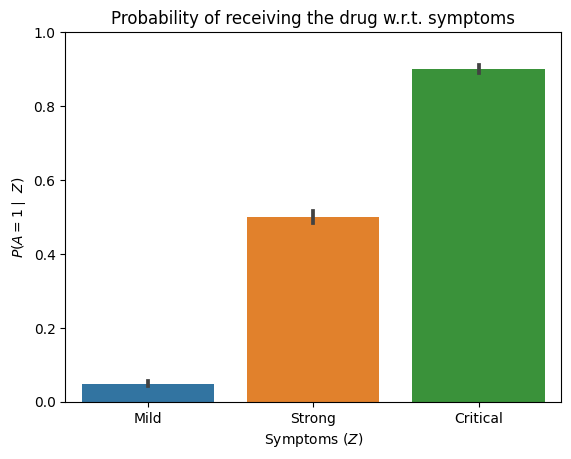

In [5]:
sns.barplot(data=data, x="Z", y="A")
plt.ylim([0, 1])
plt.ylabel("$P(A = 1 \mid Z)$")
plt.xlabel("Symptoms ($Z$)")
plt.gca().set_xticklabels(["Mild", "Strong", "Critical"])
plt.title("Probability of receiving the drug w.r.t. symptoms")
plt.show()

Interesting... 🤔

**Q:** What do you observe?

<details>
<summary>Click for answer</summary>

<strong>A:</strong> The probability of being treated clearly increases with the strength of the symptoms. This is probably due to some policy that the doctors were using to determine whether to treat patients or not.
</details>

Let's look into the relationship between the strength of the symptoms ($Z$) and the probability of survival ($Y$):

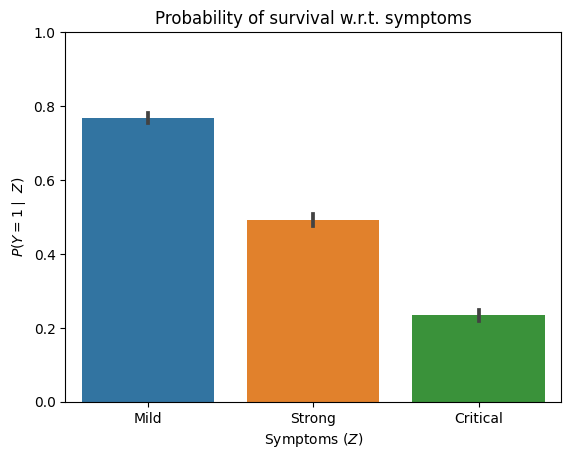

In [6]:
sns.barplot(data=data, x="Z", y="Y")
plt.ylim([0, 1])
plt.ylabel("$P(Y = 1 \mid Z)$")
plt.xlabel("Symptoms ($Z$)")
plt.gca().set_xticklabels(["Mild", "Strong", "Critical"])
plt.title("Probability of survival w.r.t. symptoms")
plt.show()

**Q:** What do you observe here?

<details>
<summary>Click for answer</summary>

<strong>A:</strong> The probability of survival clearly decreases with the intensity of the symptoms (Z).
</details>



**A graphical perspective:** You decide to question the doctors on how they decide whether or not to treat patients. They tell you the following:

> It's simple, we know that patients with stronger symptoms are less likely to survive, so we look at their symptoms and decide to treat whenever we anticipate a lower chance of survival.

Let's translate this into a causal graph over the variables $A$, $Z$, and $Y$. The doctors decide to treat or not based on their assessment of the symptoms $Z$, so there needs to be an edge $Z \rightarrow A$. The severity of the symptoms also affects the chance of survival, so there needs to be an edge $Z \rightarrow Y$. Furthermore, we include an edge from $A \rightarrow Y$, since we suspect that the treatment has an effect on survival.

We get the following graph, where $Z$ confounds the effect of $A$ on $Y$ (that is, $Z$ is a common cause of both $A$ and $Y$):
<p align="center">
    <img src="https://github.com/aldro61/eeml_causal_tutorial/raw/main/ex1a.png" width="210">
</p>

Looking at this graph, we see that information can flow from $A$ to $Y$ through two paths:
* $A \leftarrow Z \rightarrow Y$
* $A \rightarrow Y$

This means that the difference in expectations that we measured, $\mathbb{E}[Y \mid A = 1] - \mathbb{E}[Y \mid A = 0]$, can be due to any of these paths.

To get the answer we want, we need to isolate the $A \rightarrow Y$ path. **Only this will reveal the true causal effect.**

**Randomization:** Now, let's assume hypothetically that you were able to collect new data and that you could randomize the treatment assignments. Instead of using $Z$ to determine $A$, you would simply flip a coin and used this to assign treatment.

This would correspond to the following causal graph, where $Z$ does not affect $A$ anymore:
<p align="center">
    <img src="https://github.com/aldro61/eeml_causal_tutorial/raw/main/ex1b.png" width="230">
</p>

💡 This means that any association between $A$ and $Y$ that we measure must be due to the $A \rightarrow Y$ path in the graph. So using the conditional expectations to measure the treatment's causal effect (as we did above) should work.


🟢 Let's regenerate the dataset, this time using randomization to assign the treatments. Below, you will find the function that was used to generate the data. Modify it so that treatments are randomly with probability 50%. Also, take time to understand the rest of the code.


<details>
<summary>Spoiler: click here to reveal solution</summary>

You need to change this line:
<br />
<code>policy = [0.05, 0.5, 0.9]</code>
<br />
to
<br />
<code>policy = [0.5, 0.5, 0.5]</code>

</details>


In [7]:
def generate_data_ex1_randomized(n_samples=10000, seed=42, policy = [0.05, 0.5, 0.9]):
    random = np.random.RandomState(seed)

    Z = random.randint(0, 3, size=n_samples)
    
    # policy = Probability of treatment (A=a) for each Z
    A = np.array([random.rand() <= policy[z] for z in Z]).astype(int)

    # Value of Z1: 0     1    2
    survival = [[0.75, 0.25, 0.1],  # Untreated (A = 0)
                [0.95, 0.75, 0.25]] # Treated (A = 1)
    Y = np.fromiter((random.rand() <= survival[A[i]][Z[i]] for i in range(n_samples)), dtype=int)

    return pd.DataFrame(dict(Z=Z, A=A, Y=Y))

data = generate_data_ex1_randomized(policy=[0.5,0.5,0.5])
paginate(data, page_size=5)

10,000 rows, 3 columns


interactive(children=(IntSlider(value=1, description='Total pages: 2,000', max=2000, min=1, readout_format=','…

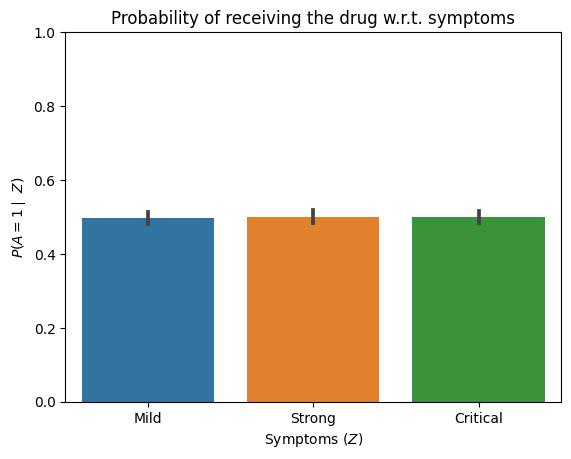

In [8]:
sns.barplot(data=data, x="Z", y="A")
plt.ylim([0, 1])
plt.ylabel("$P(A = 1 \mid Z)$")
plt.xlabel("Symptoms ($Z$)")
plt.gca().set_xticklabels(["Mild", "Strong", "Critical"])
plt.title("Probability of receiving the drug w.r.t. symptoms")
plt.show()

As expected, the strength of the symptoms does not affect the treatment assignment anymore.

Let's now look at $\mathbb{E}[Y \mid A = 1] - \mathbb{E}[Y \mid A = 0]$ again. This will correspond to the actual *average treatment effect* of our drug: $$\mathbb{E}[Y \mid do(A = 1)] - \mathbb{E}[Y \mid do(A = 0)],$$
where the $do()$-operator denotes actively setting $A=a$ for $a\in\{0,1\}$ (this is also called *intervention*).

In short, the interventional (or causal) effect is the one we sought and doing the randomization before checking for conditionals turns out to be equivalent to the causal effect we seek (at least in this example that we consider here).

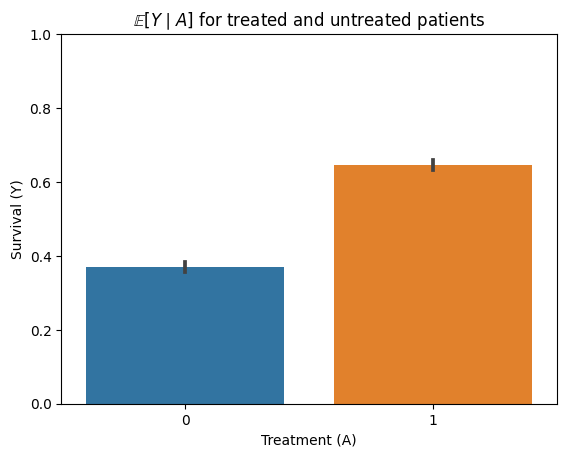

E[Y | A = 1] - E[Y | A = 0] =  0.276026454325712


In [9]:
sns.barplot(data=data, x="A", y="Y")
plt.ylim([0, 1])
plt.xlabel("Treatment (A)")
plt.ylabel("Survival (Y)")
plt.title("$\mathbb{E}[Y \mid A]$ for treated and untreated patients")
plt.show()

ate["randomization"] = data.loc[data.A == 1].Y.mean() - data.loc[data.A == 0].Y.mean()
print("E[Y | A = 1] - E[Y | A = 0] = ", ate["randomization"])

What?! The drug has a positive effect now onto survival? So, people have a better chance of surviving if they take the drug? Let's compare to what we had previously measured:


In [10]:
print("Average treatment effect of drug by estimation technique:")
pprint_ates(ate)

Average treatment effect of drug by estimation technique:


ATE,method
-0.110250,conditionals
0.276026,randomization


Indeed, the drug has a positive effect on survival. Our assessment based on conditional probabilities was **biased due to confounding** (due to the common cause, $Z$, that is, doctors were deciding who to treat based on severity).

**Final words:** Now you know the difference between conditioning and acting. When conducting data analysis, it is important to think about the nature of the data, i.e., how it could have been generated. By failing to do so, you would have concluded that the treatment was ineffective, while you have an effective solution to the rare disease right in front of you.

**Causal inference from observational data:** This is great, but we reached this conclusion by altering the data collection process via randomization, which we often cannot do. In what follows, we will explore methods that enable us to accurately estimate the effect of interventions from biased data that we observe (observational data), without being able to interfere with the collection process.

## Exercise 2: Parent adjustment (20 min)

In this exercise, we will derive and implement a very simple estimator of the average treatment effect. This will help us properly assess the causal effect of the drug in Exercise 1.

Recall the causal graph that describes our data:

<p align="center">
    <img src="https://github.com/aldro61/eeml_causal_tutorial/raw/main/ex1a.png" width="210">
</p>

Assuming all relevant variables are in this graph, we can factorize the joint distribution as follows:
\begin{align}
P(a, y, z) &= P(a | z) \cdot P(y | a, z) \cdot P(z)
\end{align}

Now, we want to reason about interventions, i.e., what would be the distribution of $Y$ in a world where:
1. We forced everyone to take the treatment ($A = 1$)
2. We forced everyone not to take it ($A = 0$). 

In both cases, we are imagining a situation where we fully control the value of $A$ and it is affected by no external forces. This corresponds to the following graph, where the hammer is used to show where we intervene:
<p align="center">
    <img src="https://github.com/aldro61/eeml_causal_tutorial/raw/main/ex2.png" width="230">
</p>

**Identification:** How do we estimate quantities that live in such interventional worlds, e.g., $\mathbb{E}[Y | do(A = a)]$, if we only have access to our confounded observational data? The key is to use our knowledge of the causal graph to perform a set of operations that convert the causal quantity (with $do$ operators) into an expression that we can evaluate from our data (with no $do$ operators). Performing such a conversion is called "identifying a causal estimand". Let's see an example.

<br />

**Parent Adjustment**

The first identification technique that we will see is called *parent adjustment*.
To begin, notice that the only difference between the full causal graph (for the observational data) and the one corresponding to an intervention is that the edge $Z \rightarrow A$ is removed. Everything else stays the same.

This means that we can write down the joint distribution of $A$, $Y$, $Z$ under an intervention $do(A = a')$ as follows:
\begin{align}
P(a, y, z \mid do(A=a')) &= P(y \mid a', z) \cdot P(z) \cdot \delta_{a=a'},
\end{align}
where most terms are simply copied from the expression of the observational joint distribution and where $\delta_{a = a'} = 1$ if and only if $a = a'$ and $0$ otherwise. This last term simply means that the interventional distribution has zero density for all values of $a$ that don't correspond to the value of the intervention ($a'$), which makes sense since the intervention forces $A = a'$ (no other values could be observed).


Now, we are only interested in the distribution of $Y$ in this interventional world, so we marginalize out the other variables:
\begin{align}
P(y \mid do(A=a')) &= \sum_a \sum_z P(a, y, z \mid do(A=a'))\\
                & <\text{Replacing the above by its definition}>\\
                &= \sum_a \sum_z P(y \mid a', z) \cdot P(z) \cdot \delta_{a=a'}\\
                & <\text{Density is zero for all $a \not= a'$}>\\
                &= 0 + \sum_z P(y \mid a', z) \cdot P(z) \cdot 1\\
                & <\text{Cleaning up a bit}>\\
                &= \sum_z P(y \mid a', z) \cdot P(z)\\
\end{align}

And we are done! We have successfully *identified* the causal estimand, since we went from a quantity that contained $do(.)$ operators to one that does not. 🎉

This result simply tells us that, to estimate the interventional distribution correctly, we need to evaluate the conditional distribution of $Y$ given $A$ and $Z$ in every subgroup (stratum) of our population corresponding to a specific value of $Z$. If you read the econometrics or social sciences literature, you may see this expression termed *standardization*, they mean the same thing.

**Average treatment effect:** Let us now use parent adjustment to estimate the quantity that we care about, the average treatment effect of our drug:
$$ATE = \mathbb{E}[Y \mid do(A = 1)] - \mathbb{E}[Y \mid do(A = 0)],$$
where
\begin{align}
\mathbb{E}[Y \mid do(A = a)] &= \sum_y y \cdot P(y \mid do(A = a))\\
                          & <\text{Explicitly summing over values of $y$}>\\
                          &= 1 \cdot P(Y=1 \mid do(A = a)) + 0 \cdot P(Y=0 | do(A = a))\\
                          & <\text{By parent adjustment}>\\
                          &= \sum_z P(Y = 1 \mid a, z) \cdot P(z).
\end{align}

If we implement this correctly, we should find the same value as what we obtained via randomization.

<br />

🟢 Take a look at the following implementation:

In [11]:
def parent_adjustment_estimator(data, a):
    """
    Use parent adjustment to estimate E[Y | do(A = a)]

    Parameters:
    -----------
    data: pd.DataFrame
        The observational data
    a: int
        The value of the intervention

    """
    estimate = 0

    # For every possible value of Z
    for z, subpop_data in data.groupby("Z"):

        # Estimate P(z)
        p_z = subpop_data.shape[0] / data.shape[0]

        # Estimate E[Y | A=a, Z=z]
        # Here, we are using discrete data, so we simply need to look at the mean
        # value of Y in some slices of our data. If you were using continuous data
        # you could use a supervised learning model of your choice to fit this
        # function (e.g., a neural network).
        expected_y = subpop_data.loc[subpop_data.A == a].Y.mean()
        
        # Add the value of this strata to the estimator
        estimate += expected_y * p_z

    return estimate


# Regenerate a fresh copy of the observational data
# We are not cheating by randomizing here. 
# There is confounding bias.
data = generate_data_ex1()

# Estimate the treatment effect using parent adjustment
ate["parent_adj"] = parent_adjustment_estimator(data, a=1) - parent_adjustment_estimator(data, a=0)

pprint_ates(ate)

ATE,method
-0.110250,conditionals
0.276026,randomization
0.274158,parent_adj


Wow, it works! Parent adjustment enabled us to use biased observational data to reach the same conclusion as we previously reached with randomization. We didn't even have to interfere with data collection. Note that the values do not match exactly since we use finite data, but in the limit the values become identical.


**A more fancy estimator**

In our example, all the variables are discrete, so we were able to estimate $\mathbb{E}[Y | A=a, Z=z]$ by filtering the data and counting the occurrence of some values. However, we could have prefered to rely on a model, trained to estimate this quantity by supervised learning. In what follows, we will see how such a model can be integrated in the estimator.

Furthermore, we could have approximated $\mathbb{E}[Y \mid do(A = a)]$ using a Monte-Carlo approximation. A what approximation? When we have a sample of size $n$, $\mathcal{S} = \{ x_1, \dots, x_n \}$, from some distribution $P(X)$, we can estimate the expectation of some quantity $f(X)$ w.r.t. $X$ as $\mathbb{E}_X \left[f(X)\right] \approx \frac{1}{n} \sum_{x_i} f(x_i)$. This means that we can rely on the following approximation:
\begin{align}
    \mathbb{E}[Y \mid do(A = a)] &= \sum_z P(Y = 1 \mid a', z) \cdot P(z)\\
                                 & <\text{Since Y is a binary variable}>\\
                                 &= \sum_z \mathbb{E}[Y \mid a', z] \cdot P(z)\\
                                 & <\text{Noting that this is an expectation w.r.t. $Z$}>\\
                                   &= \mathbb{E}_Z \left[ \mathbb{E}[Y \mid a', z] \right]\\
                                & <\text{Monte-Carlo approximation using observed values of $Z$ in our data}>\\
                                   &\approx \dfrac{1}{n} \sum_{z_i} E[Y \mid a', z_i]
\end{align}

Ok, let's implement this estimator.

🟢 Look at the code below:

In [ ]:
class OutcomeModel(object):
    """
    A model that estimates E[Y | A, Z].

    This will be very simple in our case but, in practice, this could
    have been any fancy model, such as a neural network trained by
    supervised learning.

    """
    def __init__(self):
        self.conditionals = None

    def fit(self, data):
        """
        Fit the model

        """
        # We're just going to count the frequency of each Z for each A and store it.
        # This is a dummy model, just for the purpose of our example.
        self.conditionals = np.zeros((len(data.A.unique()), len(data.Z.unique())))
        for (a, z), subset in data.groupby(["A", "Z"]):
            self.conditionals[a, z] = subset.Y.mean()

    def predict(self, a, z):
        """
        Make predictions

        """
        return self.conditionals[a, z]


def parent_adjustment_montecarlo_estimator(data, a, seed=42):
    """
    Use parent adjustment to estimate E[y | do(A = a)].
    Here, we use the empirical data distribution to estimate the expectation over Z.

    Parameters:
    -----------
    data: pd.DataFrame
        The observational data
    a: int
        The value of the intervention

    """
    # Fit an outcome model to predict E[Y | do(A = a)]
    outcome_model = OutcomeModel()
    outcome_model.fit(data)

    # Average the outcome using the empirical distribution of Z
    return np.mean([outcome_model.predict(a, z) for z in data.Z])


ate["parent_adj_mc"] = parent_adjustment_montecarlo_estimator(data, a=1) - parent_adjustment_montecarlo_estimator(data, a=0)
pprint_ates(ate)

**Remark:** This last estimator is quite interesting, since it makes use of a model, which could be of arbitrary nature. For example, the confounder is of a complex nature, such as an image (e.g., an x-ray) or text (e.g., an electronic health record), we could define the outcome model as being a neural network and simply train it via supervised learning.

## Exercise 3: From parent to back-door adjustment (20 min)

Do we really need to adjust using all causal parents? What if I can't measure all the parent variables (e.g., budget constraints, missing data)?

When we postulate a causal graph and we assume that the data distribution is generated according to it, we make an assumption about the conditional independences that exist in the distribution: *the Markov property*.

**Markovian assumption:** We assume that two (sets of) variables $A$, $B$ are independent conditioned on a (set of) variables $C$, if $C$ blocks all paths between $A$ and $B$ in the graph. This is typically written as follows:
$$
A \perp \!\! \perp_G B \mid C \Rightarrow A \perp \!\! \perp B \mid C,
$$
where $\perp \!\! \perp_G$ denotes separation in the graph (i.e., d-separation), while $\perp \!\! \perp$ denotes independence in distribution. 

<br />

Let's experiment with this a little bit. We will start by generating data according to the following graph:

<p align="center">
    <img src="https://github.com/aldro61/eeml_causal_tutorial/raw/main/ex3a.png" width="350">
</p>

and look at some dependencies between the variables:

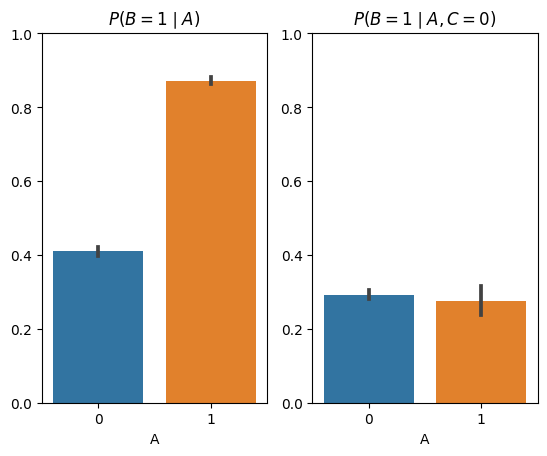

In [12]:
def generate_data_ex3a(n_samples=10000, seed=42):
    random = np.random.RandomState(seed)
    C = random.randint(0, 2, n_samples).astype(int)
    A = np.array([random.rand() < (0.1 if c == 0 else 0.8) for c in C]).astype(int)
    B = np.array([random.rand() < (0.3 if c == 0 else 0.95) for c in C]).astype(int)
    return pd.DataFrame(dict(A=A, B=B, C=C))

# Generate the data
data = generate_data_ex3a()

# Plot dependencies
f, (ax1, ax2) = plt.subplots(ncols=2)

sns.barplot(data=data, x="A", y="B", ax=ax1)
ax1.set_ylim([0, 1])
ax1.set_ylabel("")
ax1.set_title("$P(B = 1 \mid A)$")

sns.barplot(data=data.loc[data.C == 0], x="A", y="B", ax=ax2)
ax2.set_ylim([0, 1])
ax2.set_ylabel("")
ax2.set_title("$P(B = 1 \mid A, C=0)$")
plt.show()

**Q:** What do you observe here? Does it correspond to your graphical intuition?

<details>
<summary>Click for answer</summary>

<strong>A:</strong> We see that $B$ depends on $A$ if we don't condition on $C$ (we observed that the distribution of $B$ changes strongly for different values of $A$), but that it doesn't when we condition on $C$ (we observed that the distribution of $B$ did not change with $A$, as before, as soon as we knew about the value of $C$). This does correspond to what we can read off from the graph, since $C$ blocks all paths from $A$ to $B$ (regardless of edge orientation) through which statistical information can flow.
</details>

Now, let's do the same thing for the following graph:

<p align="center">
    <img src="https://github.com/aldro61/eeml_causal_tutorial/raw/main/ex3b.png" width="350">
</p>

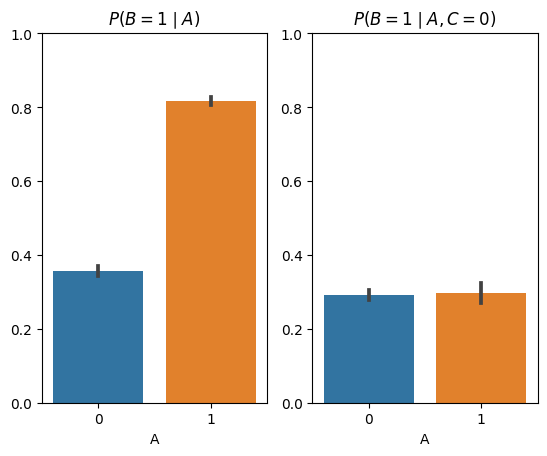

In [13]:
def generate_data_ex3b(n_samples=10000, seed=42):
    random = np.random.RandomState(seed)
    A = random.randint(0, 2, n_samples).astype(int)
    C = np.array([random.rand() < (0.1 if a == 0 else 0.8) for a in A]).astype(int)
    B = np.array([random.rand() < (0.3 if c == 0 else 0.95) for c in C]).astype(int)
    return pd.DataFrame(dict(A=A, B=B, C=C))

# Generate the data
data = generate_data_ex3b()

# Plot dependencies
f, (ax1, ax2) = plt.subplots(ncols=2)

sns.barplot(data=data, x="A", y="B", ax=ax1)
ax1.set_ylim([0, 1])
ax1.set_ylabel("")
ax1.set_title("$P(B = 1 \mid A)$")

sns.barplot(data=data.loc[data.C == 0], x="A", y="B", ax=ax2)
ax2.set_ylim([0, 1])
ax2.set_ylabel("")
ax2.set_title("$P(B = 1 \mid A, C=0)$")
plt.show()

**Q:** What do you observe here? Does it correspond to your graphical intuition?

<details>
<summary>Click for answer</summary>

<strong>A:</strong> Again, we see the same thing: $B$ depends on $A$ if we don't condition on $C$, but it doesn't when we condition on $C$. This does correspond to what we can read off from the graph, since $C$ blocks all paths from $A$ to $B$ through which statistical information can flow.
</details>

Finally, let's repeat the same thing for the following graph:

<p align="center">
    <img src="https://github.com/aldro61/eeml_causal_tutorial/raw/main/ex3c.png" width="350">
</p>

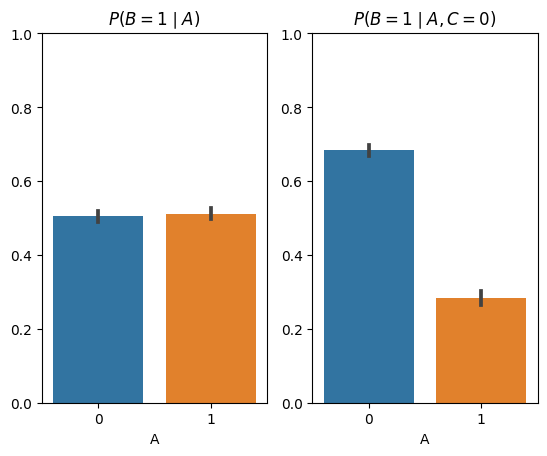

In [14]:
def generate_data_ex3b(n_samples=10000, seed=43):
    random = np.random.RandomState(seed)
    A = random.randint(0, 2, n_samples).astype(int)
    B = random.randint(0, 2, n_samples).astype(int)
    probas = random.rand(2, 2)
    C = np.array([random.rand() < probas[a, b] for a, b in zip(A, B)]).astype(int)
    return pd.DataFrame(dict(A=A, B=B, C=C))

# Generate the data
data = generate_data_ex3b()

# Plot dependencies
f, (ax1, ax2) = plt.subplots(ncols=2)

sns.barplot(data=data, x="A", y="B", ax=ax1)
ax1.set_ylim([0, 1])
ax1.set_ylabel("")
ax1.set_title("$P(B = 1 \mid A)$")

sns.barplot(data=data.loc[data.C == 0], x="A", y="B", ax=ax2)
ax2.set_ylim([0, 1])
ax2.set_ylabel("")
ax2.set_title("$P(B = 1 \mid A, C=0)$")
plt.show()

**Q:** What do you observe here? Does it correspond to your graphical intuition?

<details>
<summary>Click for answer</summary>

<strong>A:</strong> This one is very strange. 🙀 We see that $A$ and $B$ are independent, unless we condition on $C$, which makes them dependent. The $A \rightarrow C \leftarrow B$ path is called a v-structure and it has the special property of being blocked, unless we condition on $C$ which opens it. Of note, this special independence pattern only holds when $A$ and $B$ are not directly connected by a $A \rightarrow B$ or $A \leftarrow B$ edge.


Let's see an example. Assume that we have the following:
* A: being an athlete or not
* B: difficulty level of the test
* C: score in physical test

Knowing that someone is an athlete ($A$) reveals nothing about the difficulty of some arbitrary physical test ($B$); these quantities are independent. However, knowing that someone is an athelete ($A$) and achieved a very low score in the physical test ($C$) reveals that the test was probably very hard ($B$). Therefore, knowing about $C$ in addition to $A$ changed our belief in $B$.

</details>

**Putting this into practice:** Ok! Now let's use this new property that we just learned about. Suppose that we have data generated according to the following causal graph:
<p align="center">
    <img src="https://github.com/aldro61/eeml_causal_tutorial/raw/main/ex3d.png" width="230">
</p>

Let's add the following complication: we measure all variables, except $Z_1$ which requires an expensive measurement device that we can't afford.

Huh? We don't measure all parents of $A$ anymore, so we can't use parent adjustment. What should we do? Should we ask for money to buy the expensive device? 💰💰💰

Let's explore the data a little bit and then decide.

🟢 Take a look at the data-generating function and try to get an intuition of why it respects the structure of the causal graph.

In [15]:
def generate_data_ex3d(n_samples=100000, randomize=False, seed=0):
    """
    Note: we use a really big sample size to avoid any small sample glitches

    """
    random = np.random.RandomState(seed)

    n_z = 3  # Number of possible values for Z1 and Z2

    # We first sample the value of Z1 randomly (it has no causal parents)
    Z1 = random.randint(0, n_z, size=n_samples)

    # Since Z1 -> Z2, we will sample the value of Z2, conditioned on Z1
    # Let's generate random conditional probabilities
    p_z2_given_z1 = random.rand(n_z, n_z)
    p_z2_given_z1 /= p_z2_given_z1.sum(axis=1)[:, None]
    Z2 = np.array([random.choice(np.arange(n_z), p=p_z2_given_z1[z1]) for z1 in Z1]).astype(int)
    
    # Probability of treatment for each Z
    if randomize:
        # If we are randomizing treatment, we set the proba to 0.5 for any (z1, z2)
        policy = np.ones((n_z, n_z)) * 0.5
    else:
        # Here, we are not randomizing so the value of A depends on (z1, z2).
        # Let's generate random conditional probabilities P(A | Z1, Z2)
        policy = random.rand(n_z, n_z)
    
    # Sample treatment assignment based on the values of Z1 and Z2
    A = np.array([random.rand() <= policy[z1, z2] for z1, z2 in zip(Z1, Z2)]).astype(int)

    # In the graph, we have Z2 -> Y, but not Z1 -> Y.
    # Hence, the value of Y only depends on Z2 and A
    #      Value of Z2: 0     1    2
    p_y_given_a_z2 = [[0.75, 0.25, 0.1],   # Untreated (A = 0)
                      [0.95, 0.75, 0.25]]  # Treated (A = 1)
    Y = np.fromiter((random.rand() <= p_y_given_a_z2[A[i]][Z2[i]] for i in range(n_samples)), dtype=int)

    return pd.DataFrame(dict(Z1=Z1, Z2=Z2, A=A, Y=Y))


data = generate_data_ex3d(randomize=False)


Let's first see if $A$ and $Z_1, Z_2$ are dependent:

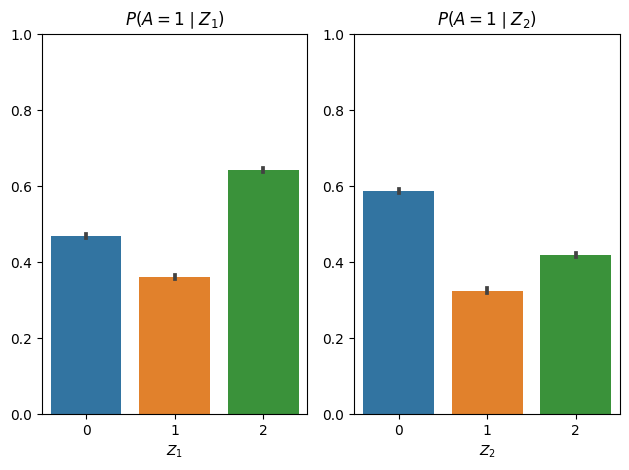

In [16]:
f, (ax1, ax2) = plt.subplots(ncols=2)

sns.barplot(data=data, x="Z1", y="A", ax=ax1)
ax1.set_ylim([0, 1])
ax1.set_xlabel("$Z_1$")
ax1.set_ylabel("")
ax1.set_title("$P(A = 1 \mid Z_1)$")

sns.barplot(data=data, x="Z2", y="A", ax=ax2)
ax2.set_ylim([0, 1])
ax2.set_xlabel("$Z_2$")
ax2.set_ylabel("")
ax2.set_title("$P(A = 1 \mid Z_2)$")

plt.tight_layout()
plt.show()

**Q:** What do you observe here? Does it correspond to your graphical intuition?

<details>
<summary>Click for answer</summary>

<strong>A:</strong> Clearly, the distribution of $A$ changes with $Z_1$ and $Z_2$, so there is a dependency between $A$ and each of these variables. This does correspond to our graphical intuition, since they are directly connected via $Z_1 \rightarrow A$ and $Z_2 \rightarrow A$ edges.
</details>

Similarly, let's check if $Z_1$, $Z_2$ are associated with $Y$ when we condition on $A$ to block any flow of information via the $Z_i \rightarrow A \rightarrow Y$ path:

In [ ]:
f, (ax1, ax2) = plt.subplots(ncols=2)

sns.barplot(data=data.loc[data.A == 0], x="Z1", y="Y", ax=ax1)
ax1.set_ylim([0, 1])
ax1.set_xlabel("$Z_1$")
ax1.set_ylabel("")
ax1.set_title("$P(Y = 1 \mid A = 0, Z_1)$")

sns.barplot(data=data.loc[data.A == 0], x="Z2", y="Y", ax=ax2)
ax2.set_ylim([0, 1])
ax2.set_xlabel("$Z_2$")
ax2.set_ylabel("")
ax2.set_title("$P(Y = 1 \mid A = 0, Z_2)$")

plt.tight_layout()
plt.show()

**Q:** What do you observe here? Does it correspond to your graphical intuition?

<details>
<summary>Click for answer</summary>

<strong>A:</strong> Clearly, the distribution of $Y$ changes with $Z_1$ and $Z_2$, so there is a dependency between $Y$ and each of these variables, even when we block the $A \rightarrow Y$ path. This does correspond to our graphical intuition, since $Z_2$ and $Y$ are directly connected via the $Z_2 \rightarrow Y$ edge and there is a path from $Z_1$ to $Y$: $Z_1 \rightarrow Z_2 \rightarrow Y$.

This also tells us that $Z_1$ and $Z_2$ are confounders, since they are both i) associated with $A$ and ii) are still associated with $Y$ when we block the $A \rightarrow Y$ path.
</details>

Ok. Now looking at the graph, we see that our treatment variable $A$ is connected to $Y$ via the following paths:
* $A \rightarrow Y$
* $A \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$
* $A \leftarrow Z_2 \rightarrow Y$

The first one is the causal path, who's strength we want to measure. The last two paths are called *back-door paths*, since they point into $A$, i.e., they enter it through the back door.

💡 Notice how conditioning on $Z_2$ should block all of the back-door paths! (even the path with the unobserved $Z_1$)

Let's check if this is supported by the data. If it is, we should see that $Z_1$ is independent of $Y$ when we condition on both i) $A$, to block the $Z_1 \rightarrow A \rightarrow Y$ path and ii) $Z_2$ to block all other paths.

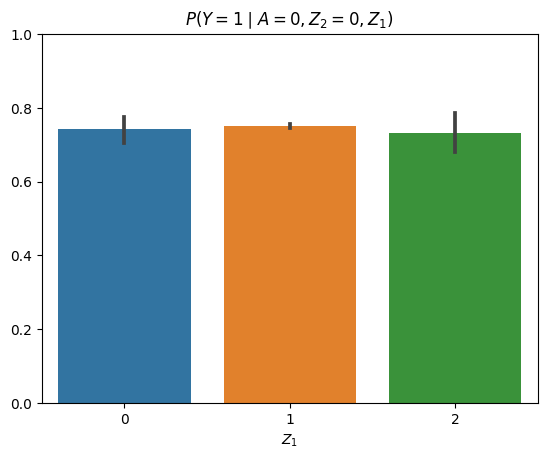

In [17]:
sns.barplot(data=data.loc[(data.A == 0) & (data.Z2 == 0)], x="Z1", y="Y")
plt.ylim([0, 1])
plt.xlabel("$Z_1$")
plt.ylabel("")
plt.title("$P(Y = 1 \mid A = 0, Z_2 = 0, Z_1)$")
plt.show()

**Q:** What do you conclude?

<details>
<summary>Click for answer</summary>

<strong>A:</strong> Changing the value of $Z_1$ has no effect here. In other words, we observe that $P(Y \mid A, Z_1, Z_2) = P(Y \mid A, Z_2)$, i.e., $Z_1 \perp \!\! \perp Y \mid \{A, Z_2\}$. This was expected, since all paths through which statistical information can flow are blocked (see the graph).

In conclusion, this means that there is absolutely no point in conditioning on $Z_1$ if we know the value of $Z_2$ (and although $Z_1$ is not measured, there is nothing to worry about, because of $Z_2$ we are good to go and we don't need to spend the money for measuring $Z_1$).
</details>

### On to estimating the treatment effect

Now, let's use this new knowledge of our data to modify our parent adjustment formula:

\begin{align}
P(y \mid do(A=a'))
                &= \sum_{a, z_1, z_2} P(a, y, z_1, z_2 \mid do(A=a'))\\
                & <\text{Simply reusing our derivation for parent adjustment (see ex. 2)}>\\
                &= \sum_{z_1, z_2} P(y \mid a', z_1, z_2) \cdot P(z_1, z_2)\\
                & <\text{Factorizing the joint distribution of $Z_1$ and $Z_2$}>\\
                &= \sum_{z_1}\sum_{z_2} P(y \mid a', z_1, z_2) \cdot P(z_1 | z_2) \cdot P(z_2)\\
                & <\text{Using our knowledge that $P(Y \mid A, Z_1, Z_2) = P(Y \mid A, Z_2)$}>\\
                &= \sum_{z_2} \left[\sum_{z_1} P(y \mid a', z_2) \cdot P(z_1 | z_2)\right] \cdot P(z_2)\\
                & <\text{Noting that $P(y \mid a', z_2)$ is constant in the sum over $z_1$}>\\
                &= \sum_{z_2} P(y \mid a', z_2) \left[\sum_{z_1} \cdot P(z_1 | z_2)\right] \cdot P(z_2)\\
                & <\text{Since $\sum_{z_1} P(z_1 | z_2) = 1$}>\\
                &= \sum_{z_2} P(y \mid a', z_2) \cdot P(z_2)\\
\end{align}

And so we do not even need to adjust for $Z_1$ here! 🎉


**What's the general pattern here?** Pearl (2009) defines the *Back-door criterion*, which states that whenever we can find a subset $\mathcal{Z}^\star$ of the parents of $A$ that blocks all backdoor paths from $Y$ into $A$, called a valid *back-door adjustment set*, we can use it to adjust in replacement of the full set of parents.

This is very convenient when some parent variables are not measured!


<br />

🟢 Take a look at the following implementation:

In [18]:
def backdoor_adjustment_estimator(data, a, adjustment_set=[]):
    """
    Use backdoor adjustment to estimate E[Y | do(A = a)]

    Parameters:
    -----------
    data: pd.DataFrame
        The observational data
    a: int
        The value of the intervention

    """
    estimate = 0

    # For every possible value zstar of all variables in our adjustment set Zstar
    for z, subpop_data in data.groupby(adjustment_set):

        # Estimate P(zstar)
        p_z = subpop_data.shape[0] / data.shape[0]

        # Estimate E[Y | A=a, Zstar=zstar]
        # Here, we are using discrete data, so we simply need to look at the mean
        # value of Y in some slices of our data. If you were using continuous data
        # you could use a supervised learning model of your choice to fit this
        # function (e.g., a neural network).
        expected_y = subpop_data.loc[subpop_data.A == a].Y.mean()
        
        # Add the value of this strata to the estimator
        estimate += expected_y * p_z

    return estimate

Now, let's compare the following estimates of the average treatment effect:
* randomization (ground truth)
* using conditional probabilities only (shouldn't work since $A \rightarrow Z_2 \rightarrow Y$ remains unblocked)
* parent adjustment (if we had the full set of parents)
* adjusting for $Z_1$ only (shouldn't work)
* backdoor adjustment (via $Z_2$)

In [19]:
def get_randomized_ate():
    data_rando = generate_data_ex3d(randomize=True)
    return data_rando.loc[data_rando.A == 1].Y.mean() - data_rando.loc[data_rando.A == 0].Y.mean()

ate = {}
ate["Conditionals (dummy)"] = data.loc[data.A == 1].Y.mean() - data.loc[data.A == 0].Y.mean()
ate["Backdoor via Z1 (dummy)"] = backdoor_adjustment_estimator(data, a=1, adjustment_set=["Z1"]) - backdoor_adjustment_estimator(data, a=0, adjustment_set=["Z1"])
ate["Randomization"] = get_randomized_ate()
ate["Parent adjustment"] = backdoor_adjustment_estimator(data, a=1, adjustment_set=["Z1", "Z2"]) - backdoor_adjustment_estimator(data, a=0, adjustment_set=["Z1", "Z2"])
ate["Backdoor via Z2"] = backdoor_adjustment_estimator(data, a=1, adjustment_set=["Z2"]) - backdoor_adjustment_estimator(data, a=0, adjustment_set=["Z2"])

print("Average treatment effect by estimation method:")
pprint_ates(ate)

Average treatment effect by estimation method:


ATE,method
0.336956,Conditionals (dummy)
0.368233,Backdoor via Z1 (dummy)
0.230995,Randomization
0.241260,Parent adjustment
0.237216,Backdoor via Z2


As you can see, we successfully estimate the average treatment effect by adjusting for $Z_2$ only. So we won't need to ask for money to buy the fancy measurement device for $Z_1$. Great! 💰

## Exercise 4: Estimation via machine learning (15 min)

Everything we did today can work with complex high-dimensional data, such as images or text. In this exercise, we will see an example.

By now, you're a real pro at causal inference. You decided to post an online add to advertise your treatment effect estimation skills. 😎

The first contract comes in. Your customer, a veterinarian, needs help with assessing the effectiveness of a treatment. By discussing with the customer, you understand that this is a simple case of ATE estimation with confounding. The nature of the confounding comes from the fact that the data was collected by a human, which was likely to assign treatment based on anticipation of the outcome, as in **Exercise 1**. The graph is as follows:
<p align="center">
    <img src="https://github.com/aldro61/eeml_causal_tutorial/raw/main/ex1a.png" width="210">
</p>

Seems easy enough.

<br />

Then, the customer tells you that they lost the detailed information about the animals that were treated. All that they have is a picture that was taken when they checked into the clinic. 

How does the customer expect us to use such data?! We certaintly cannot use parent adjustment and adjust for the value of every single pixel. Should you turn down this contract? What can you do? How do you deal with such data? 🙀

<br />

It turns out that we can use models, e.g., neural networks, as components of the estimators that we have seen in this tutorial. Now, we will see an example of an inverse probability weighting estimator, where the propensity score $P(a | z)$ is estimated using a convolutional neural network.

<br />

🟢 Start by loading the following dataset:

In [20]:
data = generate_data_ex4b()
print("The dataset contains", data.shape[0], "examples.")

Files already downloaded and verified


/Users/mzecevic/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


The dataset contains 20000 examples.


A,Y,Z_img
1,1,
1,0,
1,1,
1,1,
1,0,
1,0,
0,0,
0,0,
1,0,
0,1,

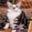
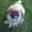
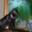
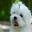
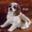
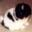
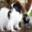
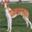
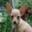
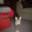

In [21]:
pd.set_option('display.max_colwidth', 100000)
HTML(data[["A", "Y", "Z_img"]].head(10).to_html(
    formatters={'Z_img': lambda im: f'<img src="data:image/jpeg;base64,{im}" width="100">'}, 
    escape=False, index=False))

Next, we will train a convolutional neural network to estimate the propensity score. Concretely, we will use the picture of each invidual as input to the network and train it to predict if they received the treatment or not.

<br />

🟢 Let's start by loading some modules and converting the data into a PyTorch dataset:

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split the data into a training and testing set
# Training set: will be used to fit a propensity score model
# Testing set: will be used to estimate the treatment effect
train_data = data.iloc[: data.shape[0] // 2]
test_data = data.iloc[data.shape[0] // 2 : ]
dataset = torch.utils.data.TensorDataset(
                    torch.tensor(np.vstack([np.expand_dims(z, axis=0) for z in train_data.Z])), 
                    torch.tensor(train_data.A.values)
                )
       
# Further split the training set to produce a validation set
# that will be used to assess overfitting.
train_size = int(len(dataset) * 0.66)
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

🟢 Next, we will define a very basic convolutional neural network, with layers that match the shape of our images:

In [23]:
class Net(nn.Module):
    """
    A basic convolutional neural network

    This code was taken from:
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

🟢 Next, we define the training loop for our model. Run the following code to train the propensity score estimator.

In [24]:
def evaluate_on_set(net, set, set_name):
    """
    Evaluate a model on a dataset

    """
    loader = torch.utils.data.DataLoader(set, batch_size=32, shuffle=True, num_workers=0)
    loss = 0
    accuracy = 0
    steps = 0
    for j, batch in enumerate(loader):
        steps += 1
        inputs, labels = batch
        inputs = inputs.float().to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss += criterion(outputs, labels).item()
        accuracy += ((torch.softmax(outputs, dim=-1)[:, 1] > 0.5).int() == labels).sum() / labels.shape[0]
    loss /= steps
    accuracy /= steps
    print(f"Evaluation ({set_name}) -- loss: {loss}  accuracy: {accuracy}")


# Define the model, optimizer, etc.
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)

for epoch in range(10):

    # Once per epoch, we calculate metrics on the whole training and validation set
    print(f"Epoch {epoch + 1}:")
    evaluate_on_set(net, train_set, "train")
    evaluate_on_set(net, val_set, "valid")
    print()

    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        inputs = inputs.float().to(device)  # Z (image)
        labels = labels.to(device)  # A (treatment)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print('Finished Training')

Epoch 1:
Evaluation (train) -- loss: 0.6929914648982062  accuracy: 0.5034722089767456
Evaluation (valid) -- loss: 0.6930342127229566  accuracy: 0.5058411359786987

Epoch 2:
Evaluation (train) -- loss: 0.6564994468781107  accuracy: 0.6336050629615784
Evaluation (valid) -- loss: 0.660568686289208  accuracy: 0.6185747385025024

Epoch 3:
Evaluation (train) -- loss: 0.6231107554861889  accuracy: 0.6751207709312439
Evaluation (valid) -- loss: 0.6354838782381789  accuracy: 0.6679322719573975

Epoch 4:
Evaluation (train) -- loss: 0.6157219324998809  accuracy: 0.6903683543205261
Evaluation (valid) -- loss: 0.6266963284149348  accuracy: 0.6872079372406006

Epoch 5:
Evaluation (train) -- loss: 0.6176623906490307  accuracy: 0.6813104152679443
Evaluation (valid) -- loss: 0.6279410307652482  accuracy: 0.6778621673583984

Epoch 6:
Evaluation (train) -- loss: 0.609354853918011  accuracy: 0.6905193328857422
Evaluation (valid) -- loss: 0.6213693212125903  accuracy: 0.6950934529304504

Epoch 7:
Evaluatio

🟢 Then, we code a simple function to evaluate the propensity score using the trained neural network:

In [25]:
def propensity_score(net, z, a):
    """
    Get propensity score from trained neural network

    """
    # Apply softmax to network output to get treatment probabilities
    return torch.softmax(net(torch.tensor(np.expand_dims(z, axis=0)).float().to(device)), dim=-1)[0, a].item()

Let's look at the propensity score of the individuals in our dataset:

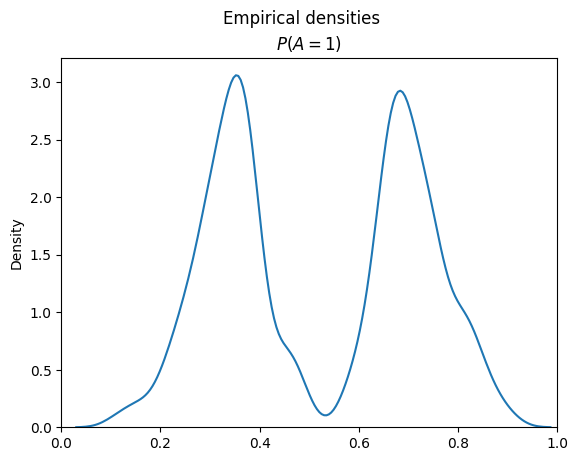

In [26]:
f, (ax1) = plt.subplots(ncols=1, sharex=True, sharey=True)
sns.kdeplot(data.Z.apply(lambda z: propensity_score(net, z, 1)).values, ax=ax1)
ax1.set_xlim(0, 1)
plt.suptitle("Empirical densities")
ax1.set_title("$P(A = 1)$")
plt.show()

Interesting, there are two modes in the distribution of estimated propensity scores!
But what do they correspond to?
Let's look at some example images from those modes.

In [27]:
diff_prop = data.Z[:10].apply(lambda z: propensity_score(net, z, 1))
print(diff_prop)

0    0.409194
1    0.684919
2    0.198737
3    0.729941
4    0.741872
5    0.674973
6    0.728386
7    0.583086
8    0.700865
9    0.452551
Name: Z, dtype: float64


We see that image with ID=0 represents the first mode, whereas image with ID=1 represents the second mode.
Let's look at those images, maybe we can spot something:

,Z_img
0,
1,

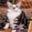
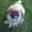

In [28]:
HTML(data[["Z_img"]].head(2).to_html(
    formatters={'Z_img': lambda im: f'<img src="data:image/jpeg;base64,{im}" width="100">'}, 
    escape=False, index=True))

Hmm, we can see a cat and a dog, interesting!
Could it be that if we were to group by whether an image depicts a cat or a dog, we would extract the modes?

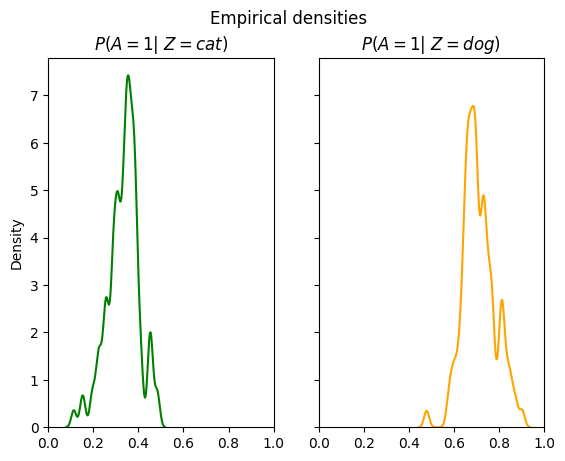

In [29]:
f, (ax2, ax3) = plt.subplots(ncols=2, sharex=True, sharey=True)
sns.kdeplot(data.loc[data.Z_ == 0].Z.apply(lambda z: propensity_score(net, z, 1)).values, ax=ax2, color="green")
sns.kdeplot(data.loc[data.Z_ == 1].Z.apply(lambda z: propensity_score(net, z, 1)).values, ax=ax3, color="orange")
ax2.set_xlim(0, 1)
ax3.set_xlim(0, 1)
plt.suptitle("Empirical densities")
ax2.set_title("$P(A = 1 | Z=cat)$")
ax3.set_title("$P(A = 1 | Z=dog)$")
plt.show()

Interesting, the modes seem to correspond to cats and dogs! So catness and dogness must have been a source of confounding here.

🟢 Finally, we implement an inverse probability weighting estimator (as described in Exercise 4) to estimate the ATE using our neural-network-based propensity score estimator. Take a look at the code and the comments:

In [30]:
def ate_propensity_nn(data):

    # Get propensity score P(A = 1 | Z) for all individuals
    propensity_scores = data.Z.apply(lambda z: propensity_score(net, z, 1)).values

    # The danger with propensity scores, especially when using models to estimate it,
    # is that you might get some really small values (due to modeling imperfections).
    # When this happens, it can cause the reweighting to produce huge values that will
    # dominate the estimated value. To avoid this, we can use clipping. Here, clipping
    # is disabled since we use the 0% and 100% percentiles as bounds.
    propensity_scores = np.clip(propensity_scores, 
                                np.percentile(propensity_scores, 0), 
                                np.percentile(propensity_scores, 100)
                            )

    # Estimate E[Y | do(A = 1)]
    y_do_a1 = (1 / data.shape[0]) * (data.loc[data.A == 1].Y.values / propensity_scores[data.A == 1]).sum()

    # Estimate E[Y | do(A = 0)]
    y_do_a0 = (1 / data.shape[0]) * (data.loc[data.A == 0].Y.values / (1 - propensity_scores[data.A == 0])).sum()

    return y_do_a1 - y_do_a0


def randomized_ate():
    """
    This function provides a randomization-based oracle ATE for comparison to the IPW estimator.

    """
    data = generate_data_ex4b(randomize=True)
    return data.loc[data.A == 1].Y.mean() - data.loc[data.A == 0].Y.mean()


ate = {"randomization": randomized_ate(),
       "conditionals": data.loc[data.A == 1].Y.mean() - data.loc[data.A == 0].Y.mean(),
       "trained model": ate_propensity_nn(test_data)}

pprint_ates(ate)

Files already downloaded and verified


/Users/mzecevic/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


ATE,method
0.175462,randomization
-0.094057,conditionals
0.123334,trained model


You should get an estimate that is somewhat close to the ground truth. In practice, since we are using modeling, we might not get a perfect result. Getting a number that is at least of the same sign as the ground truth (obtained via randomization) is already a nice achievement. If you get something that is really far from the ground truth, re-train the neural network and see if a different initialization gives a better result.

## Exercise 5: Causal Structure Learning (10 min)

This is the question of concern now. 

We have seen why causality is needed in machine learning by observing a hopeless situation, where regular machine learning fails.

We have seen all key elements of reasoning, and how they connect to what we already know from regular probability theory.

But now that we know what an SCM is, how do we get it, or *how do we even get only the graph?*

In the following, we will use show the application of two different methods from the causal discovery literature.

* The first algorithm comes from the family of constraint-based methods. The first ever proven both sound and complete causal discovery algorithm, **Fast Causal Inference** (Spirtes et al., 2000), FCI for short. FCI works both fast and gives guarantees, however, comes at the lack of being able to discern graphs which share a notion of equivalence (i.e., we usually won't get the exact, unique graph of our problem at hand).

  The algorithm exploits *conditional independences* found in the data to construct the graph by adhering to what is known as $d$-separation, a graphical criertion which establishes an equivalence to the former by the Markov condition and faithfulness, formally $A \underset{P}{\perp} B | C \iff A \underset{G}{\perp} B | C$ where an independence in $P$ is equivalent to a separation in graph $G$. 

Be assured, we need not go in the details here, but we will simply explore our original biology example using FCI.

* The second algorithm is a more recent one that disconnects from causal guarantees (i.e., is really concerned with evaluating sensible structures) but is very effective, NOTEARS (Zheng et al. 2018), NT for short. Unfortunately, the algorithm scales cubically in the number of dimensions $d, \mathcal{O}(d^3)$ rendering it restrictive but it offers a complete continuous-optimization characterization of the structure learning problems.

  The algorithm optimizes the mean-squared error (MSE) over DAGs, where a DAG is guaranteed via convergence to an acylicity constraint.

Again, be assured, we need not go in the details here, but we will also explore our original biology example using NT.

In [ ]:
def graph_induction(D, method):

    if method == "notears":
        G_pred = notears_linear(D, lambda1 = .1, loss_type = 'l2')
    elif method == "fci":
        G_pred = fci(D, verbose=False)
        G_pred = G_pred[0].graph

    return G_pred

Let's load our data again. Note that we are going to only look at our observational data i.e., the data which originally did not help us discern the causal system, since we did not ask for a causal model. That is, we will try to find the true causal graph of $A\leftarrow C\rightarrow B$ just from data points. This time around we will asumme that we observe the confounder $C$ (but we don't know yet whether it is actually a confounder, since of course, we want to know the graph now).

<p align="center">
    <img src="https://github.com/aldro61/eeml_causal_tutorial/raw/main/ex3a.png" width="350">
</p>

So, the above structure represents the true data generating process, where C depicts our confounder, A depicts the phenotype and B depicts the activity of gene 'B'.

In [ ]:
df = pd.read_csv("Dataset-Example-Phenotype-and-Genes-Nonlinear.csv")

df = df.loc[:,["confounder", "gene_B", "phenotype"]] # C, B, A respectively in above graph
paginate(df, page_size=5)

In [ ]:
D = df.to_numpy()

G_pred_fci = graph_induction(D, method="fci")
G_pred_nt = graph_induction(D, method="notears")

In [ ]:
dims = len(df.columns)
dict_visualization = {
    "Fast Causal Inference Algorithm": G_pred_fci,
    "NOTEARS Algorithm": G_pred_nt,
}

sharex = sharey = True
experiment_description = f'''
Inferring the Causal Graph of our Biology Data Set from purely Observational Data\n
Top Row shows FCI/NT predicted graph as an adjacency matrix, Bottom Row shows the actual graph
'''
suptitle = f'{experiment_description}'

commonlabel = list(df.columns)
utils.plot_all_individual(list(dict_visualization.values()),
                    list(dict_visualization.keys()),
                    suptitle=suptitle,
                    alt_form=(1,2),
                    alt_size=(8,6),
                    sharex=sharex,
                    sharey=sharey,
                    commonlabel=commonlabel)

dict_cyc_vis = dict_visualization
utils.plot_digraphs_and_cycles(list(dict_cyc_vis.values()), list(dict_cyc_vis.keys()), commonlabel,
                    alt_size=(13,2), arrowsize=14, font_size=10, node_size=250, no_cycles=True)

As expected, both algorithms identify the structure, but FCI only up to Markov Equivalence whereas NOTEARS manages to find the exact causal graph (however, there is no guarantee --- beginner's luck you might call it here).

**To conclude we can use the available data in different, creative ways to find out about its origin, that is, the data generating SCM's causal graph - amazing!**

## ⭐⭐⭐ THE END ⭐⭐⭐ 

Thanks for joining today!
Enjoy the Continual Causality Bridge and AAAI 2024.